# MAGMA experimnetations

## Artificial data : Common HP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Exponentiated Quadratic Kernel

In [2]:
N = 100
M = 5

t0 = 0
tN = 10 + 1e-3

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [3]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [4]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[67.13818656  6.85391133]


In [5]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [6]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [7]:
Theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
Sigma = np.random.uniform(0, 1)

print(Theta)
print(Sigma)

[35.81609993  7.18845368]
0.9349740220925199


In [8]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta, common_T)
    Psi_Theta_Sigma = C_Theta + Sigma * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(5, 100)


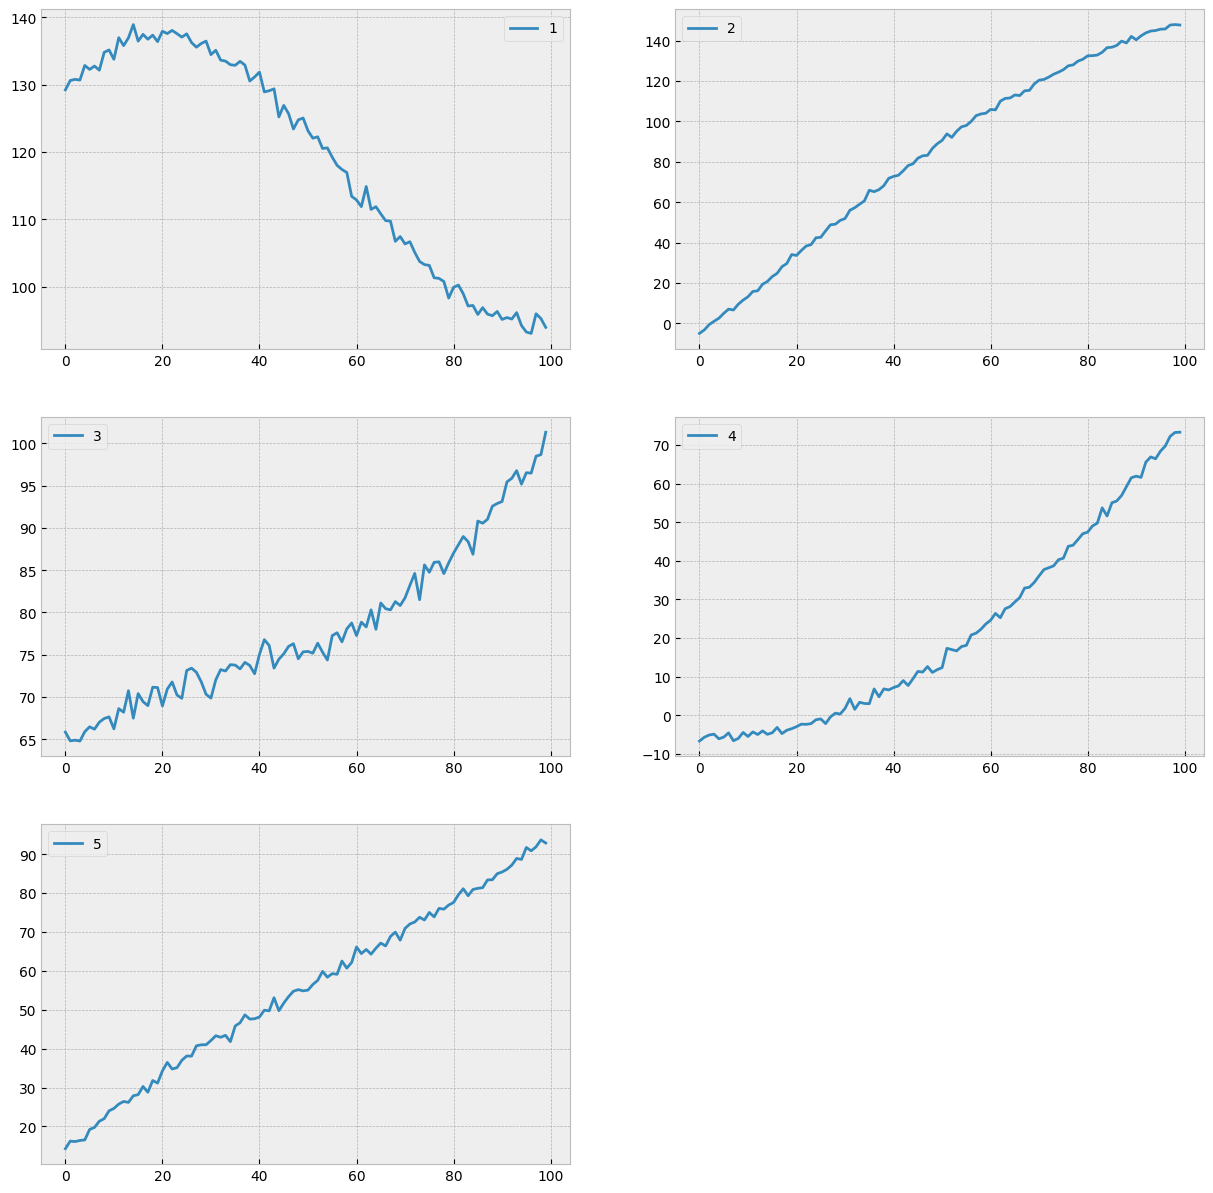

In [14]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Y[i - 1], label=f"{i}")
    plt.legend()
plt.show()

In [15]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=m0, 
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]), 
    Theta=np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]), 
    Sigma=np.random.uniform(0, 1),
    common_hp_flag=True,
    save_history_flag=True,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [16]:
model.fit(max_iterations=50, eps=1e-6)

MAGMA Training: 100%|██████████| 50/50 [23:01<00:00, 27.63s/it]


In [17]:
history = model.history
len(history)

51

In [18]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

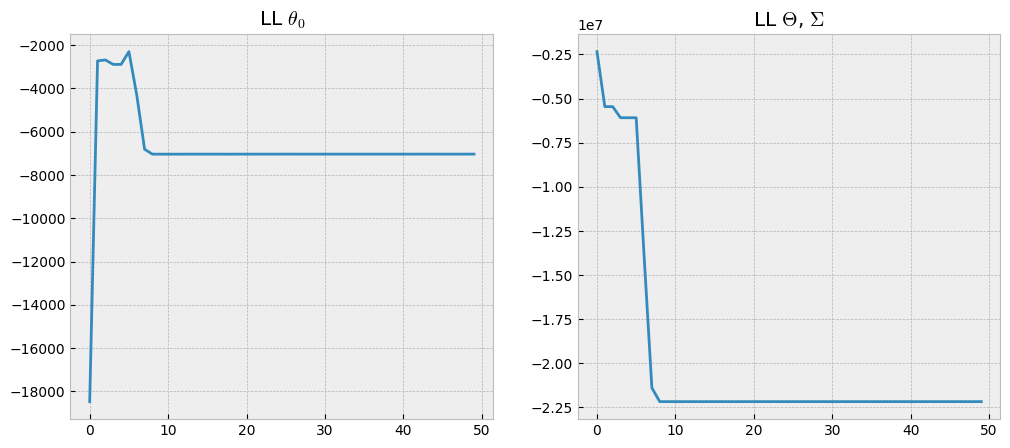

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [20]:
Sigma = []
for epoch_history in history:
    Sigma.append(epoch_history["Sigma"])

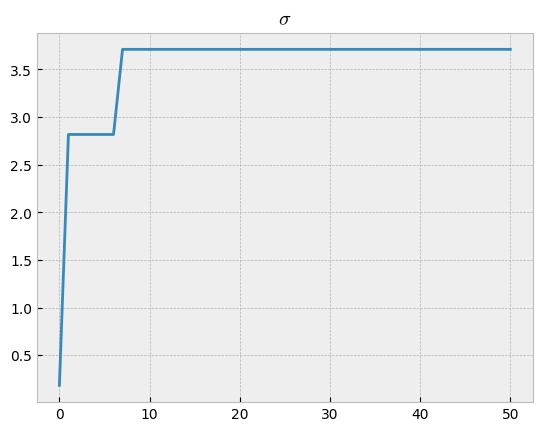

In [21]:
plt.plot(Sigma)
plt.title("$\sigma$")
plt.show()

In [22]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

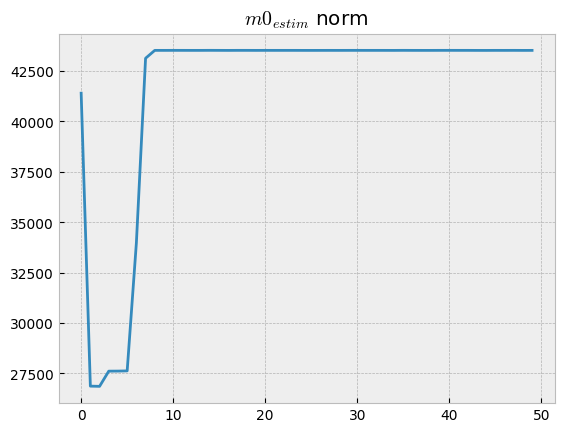

In [23]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()

In [24]:
theta0 = []
for epoch_history in history:
    theta0.append(epoch_history["theta0"])
theta0 = np.array(theta0)
print(model.theta0)

[116.17150727   3.10666719]


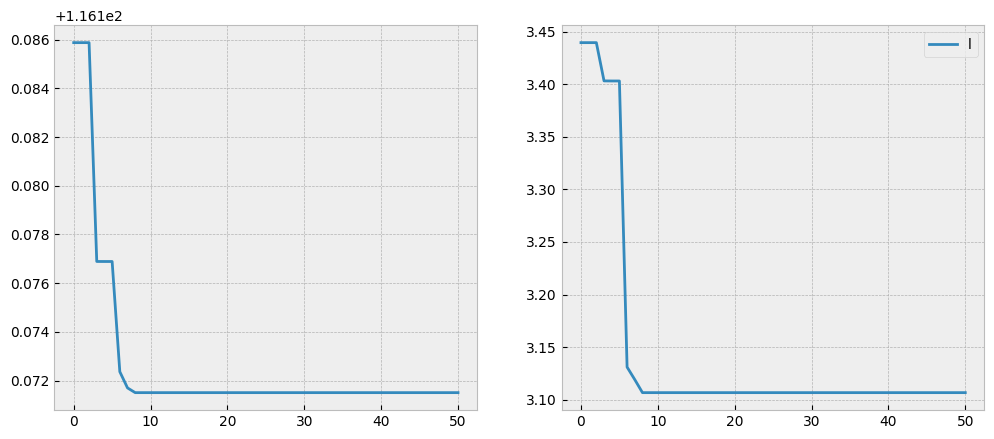

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0[:, 0], label="v")
plt.subplot(1, 2, 2)
plt.plot(theta0[:, 1], label="l")
plt.legend()
plt.show()

In [26]:
Theta = []
for epoch_history in history:
    Theta.append(epoch_history["Theta"])
Theta = np.array(Theta)
print(model.Theta)

[109.35671631   8.93151218]


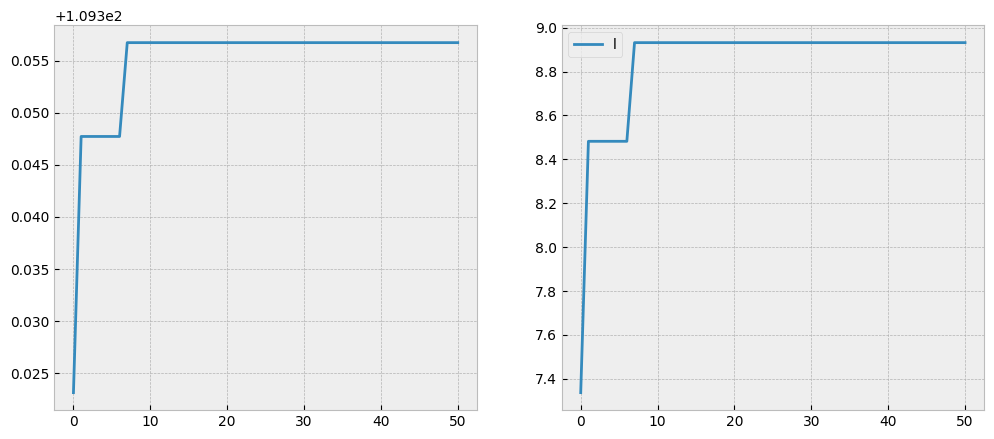

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Theta[:, 0], label="v")
plt.subplot(1, 2, 2)
plt.plot(Theta[:, 1], label="l")
plt.legend()
plt.show()